# Load a HDF Tomogram

This is a worked example of how to organise and load a tomogram that has been segmented in preparation for neural network training. To keep things simple and consistent, we expect all hdf's to be of the same shape (ie all segments should be of the same dimension) and defined in a simple dictionary with key/value pairs defining the label of the layer and the filepath of the raw image data.

In [2]:
import h5py
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [3]:
def load_image( filepath, leaf='MDF/images/0/image', normalise=255, astype='uint8' ):
    """ load the specified hdf file and look for a 3d intensity map; normalise output """
    f = h5py.File(filepath)
    # f.visit(print)

    d = f[leaf].value
    print('%s, shape: %s' % (filepath, d.shape,))
    n = np.min(d)
    m = np.max(d)
    out = ( (d - n) * (1/(m - n)) * normalise ).astype(astype)
    print('  min: %s->%s, max: %s->%s, mean: %s->%s, std: %s->%s' % (n,np.min(out), m,np.max(out), np.mean(d),np.mean(out), np.std(d),np.std(out),))
    return out

In [35]:
def crop( data, x=None, y=None, z=None, astype='uint8'):
    """ crop out a 3d portion of the 3d matrix with tuples as defined on axes """
    def _slice( tup ):
        return slice(None) if not tup else slice(tup[0],tup[1])
    return data[ _slice(x), _slice(y), _slice(z)].astype(astype)

In [5]:
def show( data, title=None, low_pass_filter=0 ):
    """ crude display out data """
    vmin=np.min(data)
    vmax=np.max(data)
    
    fig=plt.figure()
    if title:
        fig.suptitle(title, fontsize=16)
        
    x,y,z=np.where(data>low_pass_filter)
    v=data[np.where(data>low_pass_filter)]
    
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(x,y,z, c=v, marker='.', vmin=vmin,vmax=vmax, s=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    return plt.show()

In [6]:
!ls /gpfs/slac/cryo/fs1/g/tomo-seg/mut_05/

BACHDTomo5A3S410k70e-.rec  r2d_15
actin			   r2d_16
actin_mskout.hdf	   r2d_17
checkthr_display.hdf	   r2d_18
chimera.py		   r2d_19
chimera.pyc		   r2d_20
circle_msk.hdf		   r2d_21
circle_mskout.hdf	   rawtomograms
circle_mskout_lp.hdf	   ribo_msk.hdf
circles			   ribo_mskout.hdf
e2boxercache		   ribo_mskout_lp.hdf
filtertool_default.txt	   ribosome
info			   tmp.hdf
initial_models		   tmp1.hdf
microtubule		   tomoseg_actin.hdf
movie1.py		   tomoseg_actin2.hdf
movie1.pyc		   tomoseg_actin3.hdf
movie2.py		   tomoseg_actin3_bin2.hdf
movie2.pyc		   tomoseg_actin3_bin2_msk.hdf
mt_mskout.hdf		   tomoseg_actin_ubin.hdf
neuron_05.ipynb		   tomoseg_circle0.hdf
nnet_save.hdf		   tomoseg_memb0.hdf
nnet_save_actin.hdf	   tomoseg_memb2.hdf
nnet_save_actin2.hdf	   tomoseg_mt.hdf
nnet_save_actin3.hdf	   tomoseg_mt_msk.hdf
nnet_save_actin_ubin.hdf   tomoseg_mt_tmp.hdf
nnet_save_circle0.hdf	   tomoseg_thinginmt.hdf
nnet_save_junk0.hdf	   tomoseg_thinginmt_bin2.hdf
nnet_save_memb0.hdf	   tomoseg_thingi

Specify the labels and filepaths of the layers of this tomogram

In [7]:
base_dir="/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05/"
tomo = {
    'raw':        base_dir+"/rawtomograms/raw_tomo_bin4.hdf",
    'actin':      base_dir+"/tomoseg_actin3_bin2.hdf",
    'membrane':   base_dir+"/tomoseg_memb2.hdf",
    'microtuble': base_dir+"/tomoseg_mt.hdf",
    'tube':       base_dir+"/tomoseg_tubenearmt_bin2.hdf",
}

Load the data into a dictionary for easier handling - use a dictionary comprehension to keep things compact

In [8]:
all_data = { label:load_image(filepath) for (label,filepath) in tomo.items() }

/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05//rawtomograms/raw_tomo_bin4.hdf, shape: (62, 1280, 960)
  min: -3.0->0, max: 3.0->255, mean: 0.0053402698->127.2324651640205, std: 0.9488565->40.320958669870464
/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05//tomoseg_actin3_bin2.hdf, shape: (62, 1280, 960)
  min: -0.06881775->0, max: 2.9694102->255, mean: 0.03241927->7.916089575982863, std: 0.093509994->7.8817281218940805
/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05//tomoseg_memb2.hdf, shape: (62, 1280, 960)
  min: -0.0908308->0, max: 1.5630476->255, mean: 0.0016439599->13.859961935063843, std: 0.021104122->3.2798332437476136
/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05//tomoseg_mt.hdf, shape: (62, 1280, 960)
  min: -0.0389266->0, max: 1.3787652->255, mean: 0.020886332->10.266881956695228, std: 0.049475484->8.90135117322233
/gpfs/slac/cryo/fs1/g/tomo-seg/mut_05//tomoseg_tubenearmt_bin2.hdf, shape: (62, 1280, 960)
  min: -0.03544575->0, max: 2.370061->254, mean: 0.055367813->9.103495503087197, std: 0.07107121->7.557947309

Let's just crop down to some smaller cubes voxels for some quick visualisation

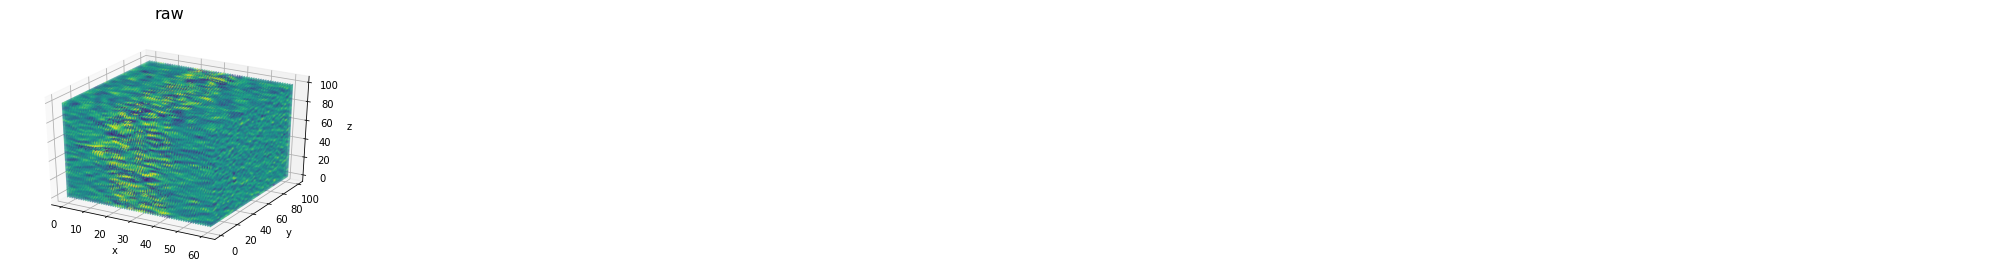

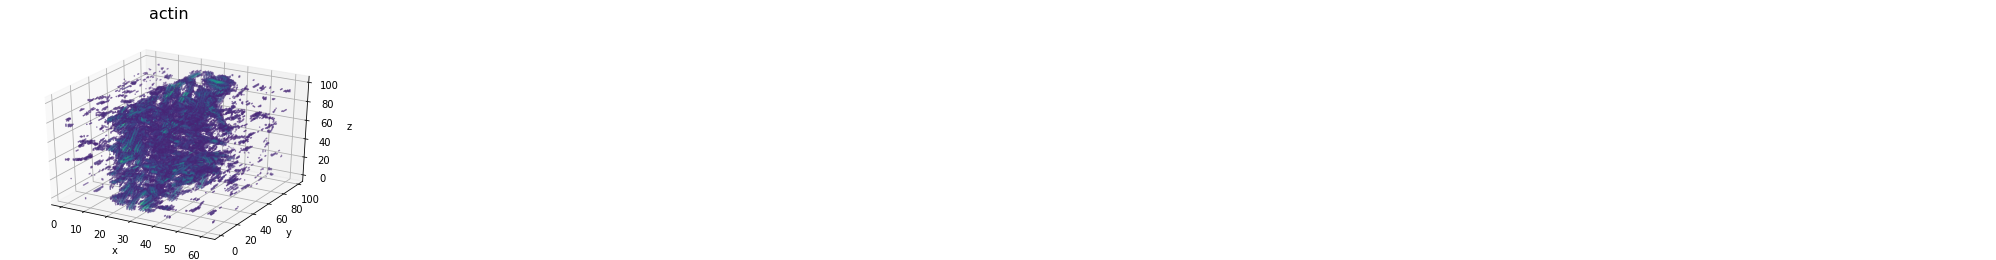

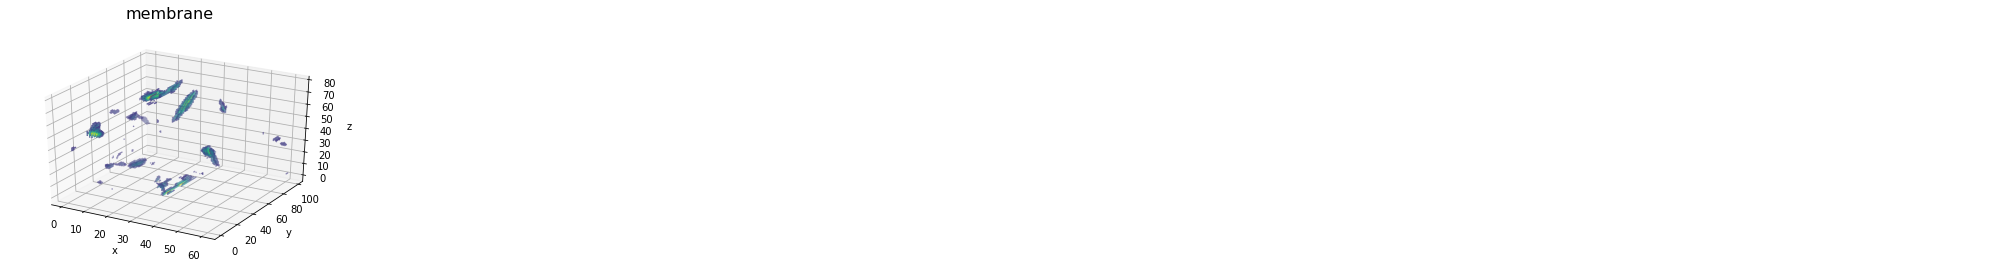

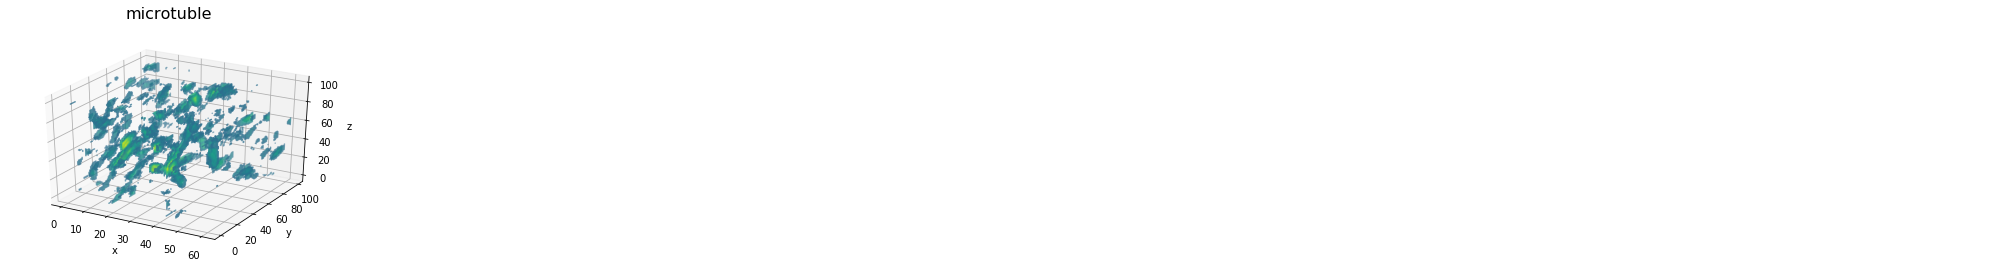

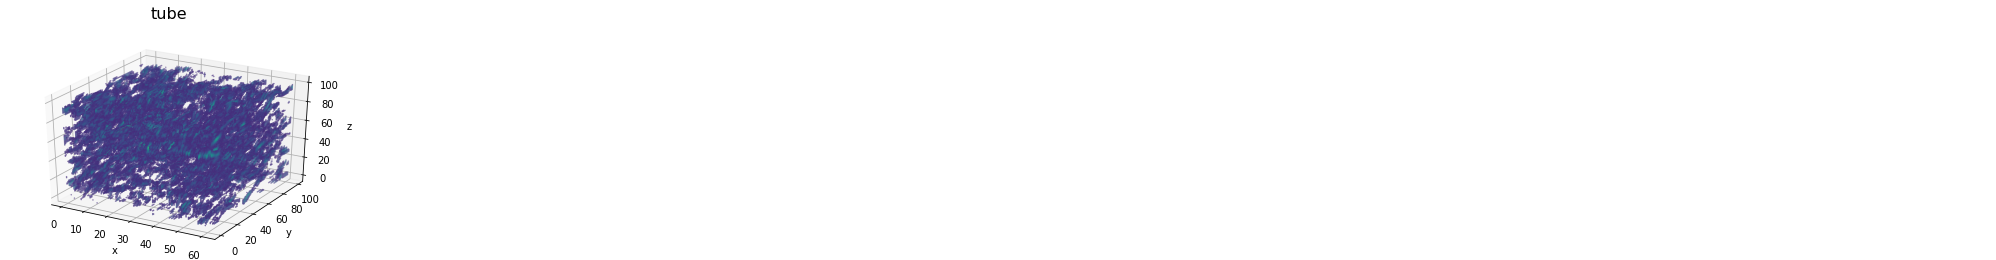

In [9]:
cropped_data = { label:crop( data, x=None, y=(400,500), z=(400,500) ) for (label,data) in all_data.items() }
for label, data in cropped_data.items():
    show( data, title=label, low_pass_filter=16 )

Need to be able to randomly choose a small cube of n voxels so that we may pass into the training

In [10]:
np.random.seed(200)
def get_random( size=32, x=62, y=1280, z=960 ):
    dx = np.random.randint(low=0, high=x-size)
    dy = np.random.randint(low=0, high=y-size)
    dz = np.random.randint(low=0, high=z-size)
    return (dx,dx+size), (dy,dy+size), (dz,dz+size)

In [11]:
for i in range(10):
    print( get_random() )

((26, 58), (617, 649), (784, 816))
((4, 36), (810, 842), (695, 727))
((12, 44), (1103, 1135), (345, 377))
((14, 46), (219, 251), (185, 217))
((25, 57), (139, 171), (902, 934))
((10, 42), (312, 344), (513, 545))
((7, 39), (1075, 1107), (923, 955))
((9, 41), (1167, 1199), (641, 673))
((14, 46), (279, 311), (85, 117))
((24, 56), (362, 394), (803, 835))


Let's apply this and show a bunch of random cubes in the tomogram

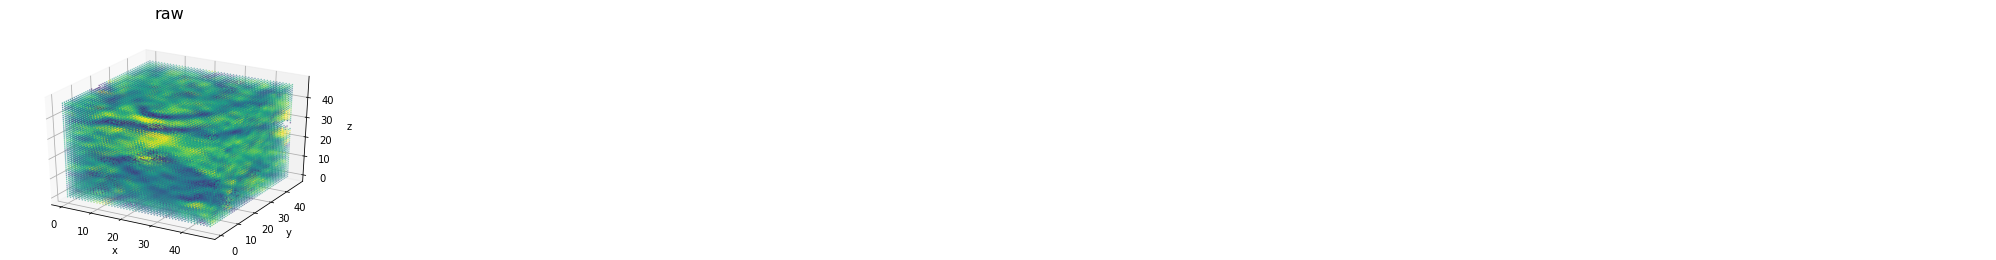

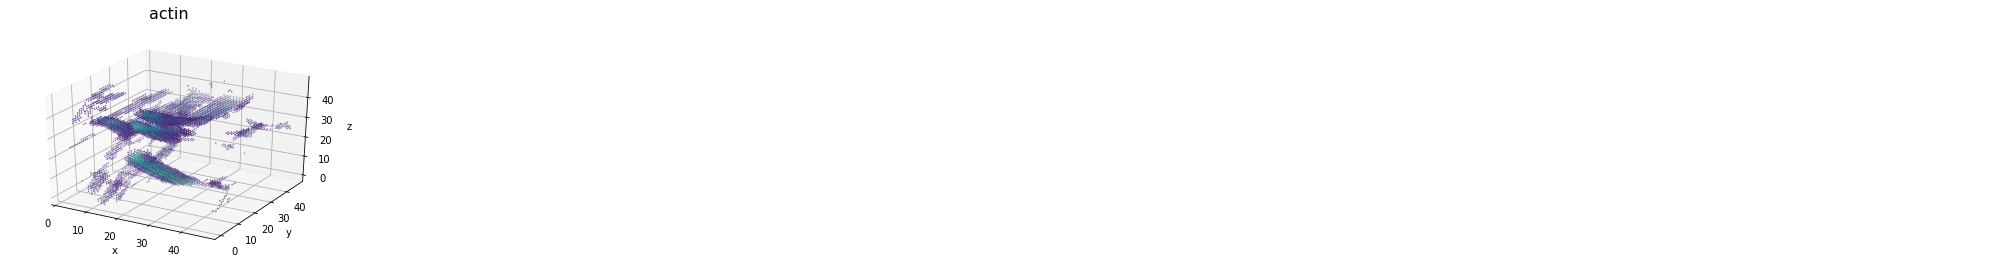

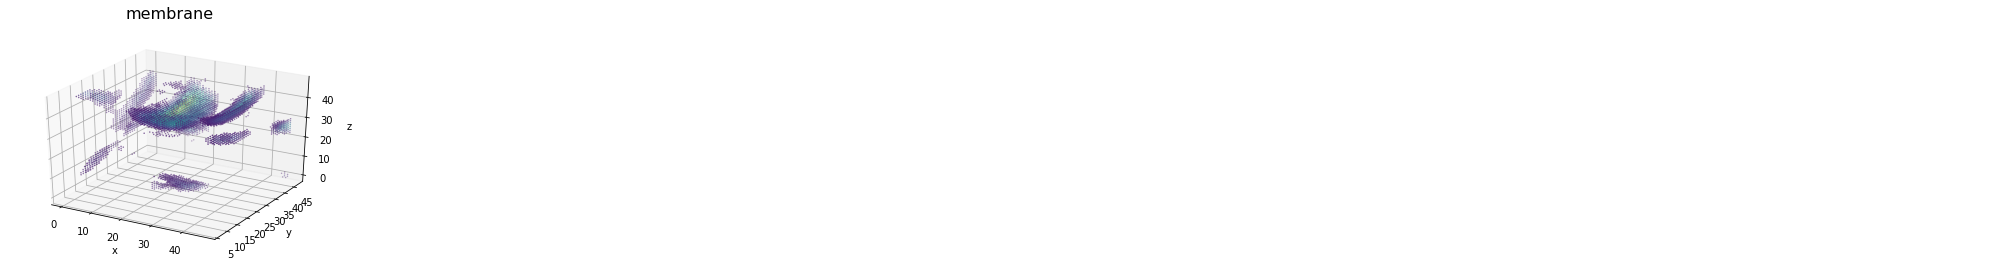

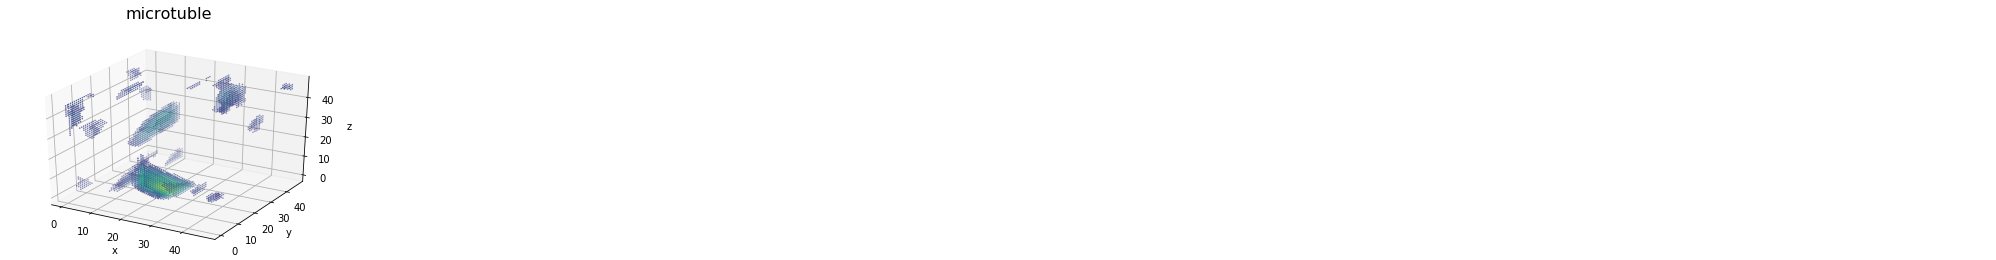

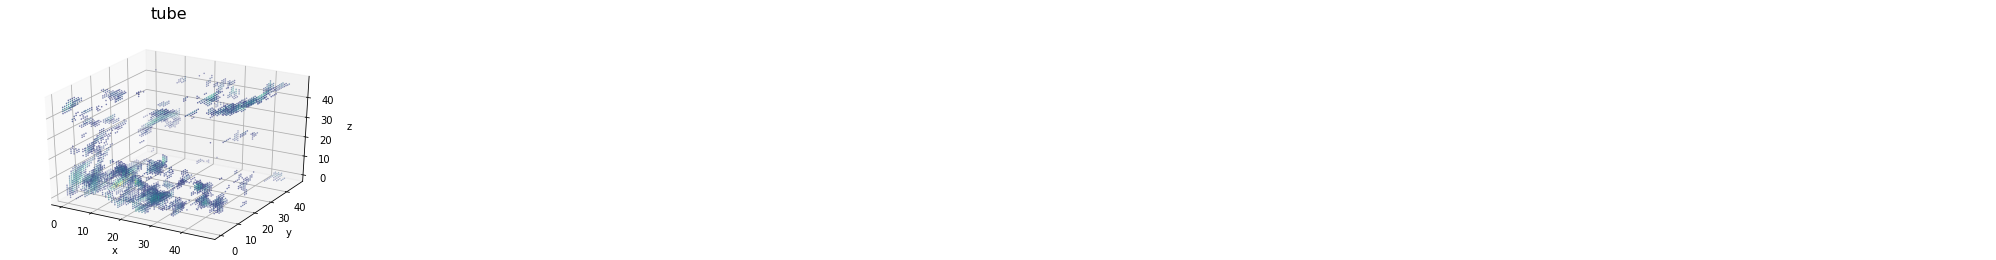

In [13]:
small_data = {}
dx,dy,dz = get_random(size=48)
for (label,data) in all_data.items():
    small_data[label] = crop( data, x=dx, y=dy, z=dz )
for label, data in small_data.items():
    show( data, title=label, low_pass_filter=16 )

What we need to do now is to create an matrix whereby the 4th dimension represents an enum of which label is present at each voxel. We might hae to deal with the fact that different layers have a positive signal.

let's test some code to allow numpy tell us which axis has the highest value:

In [14]:
a = np.random.randint( 0,9, (2,3,4) )
a

array([[[0, 4, 2, 5],
        [2, 4, 0, 3],
        [7, 8, 8, 3]],

       [[1, 8, 0, 4],
        [6, 3, 4, 4],
        [6, 2, 0, 4]]])

In [16]:
a.argmax( axis=0 )

array([[1, 1, 0, 0],
       [1, 0, 1, 1],
       [0, 0, 0, 1]])

ie, along axis 0, it will provide the a matrix of indices indicating which second axis has the largest value - this will be our 1-hot matrix indicating what label of data is at each and every voxel. therefore, what we need to do is to stack the each of the layers into a larger dimension matrix

let's first define a enum of the labels to a static number for all future references

In [20]:
classes = {
    'actin': 0,
    'membrane': 1,
    'microtuble': 2,
    'tube': 3
}

In [45]:
size = 2
cube = np.empty( [len(classes),size,size,size] )
dx,dy,dz = get_random(size=size)
for (label, class_number) in classes.items():
    data = crop( all_data[label], x=dx, y=dy, z=dz )
    # print( '%s -> %s:\n%s' % (label,classes[label],data))
    cube[class_number] = data
print("cube: ")
print( cube )

cube: 
[[[[ 5.  5.]
   [ 5.  5.]]

  [[ 5.  5.]
   [ 5.  5.]]]


 [[[13. 14.]
   [14. 14.]]

  [[14. 14.]
   [13. 14.]]]


 [[[11. 10.]
   [11. 11.]]

  [[11. 10.]
   [11. 11.]]]


 [[[ 6.  4.]
   [ 5.  2.]]

  [[12. 10.]
   [11.  8.]]]]


In [46]:
one_hot = cube.argmax( axis=0 )
print( "one-hot: ")
print( one_hot )

one-hot: 
[[[1 1]
  [1 1]]

 [[1 1]
  [1 1]]]


seems to work... so lets wrap it up in a function:

In [49]:
def get_random_onehot( size=48, classes=classes ):
    cube = np.empty( [len(classes),size,size,size] )
    dx,dy,dz = get_random(size=size)
    for (label, class_number) in classes.items():
        cube[class_number] = crop( all_data[label], x=dx, y=dy, z=dz )
    return cube.argmax( axis=0 )

In [61]:
one_hot = get_random_onehot()
print( one_hot )

[[[2 2 2 ... 2 2 2]
  [2 2 2 ... 1 1 2]
  [2 2 2 ... 1 1 1]
  ...
  [1 0 0 ... 1 1 2]
  [1 1 0 ... 0 1 1]
  [1 1 0 ... 0 1 1]]

 [[2 2 2 ... 1 2 1]
  [2 2 2 ... 1 1 1]
  [2 2 2 ... 1 1 1]
  ...
  [2 2 2 ... 0 1 1]
  [2 2 2 ... 0 1 1]
  [0 2 2 ... 0 1 1]]

 [[2 2 2 ... 1 1 3]
  [2 2 2 ... 1 3 3]
  [2 2 2 ... 1 1 3]
  ...
  [2 2 2 ... 0 1 3]
  [0 2 2 ... 0 0 1]
  [0 2 2 ... 0 0 1]]

 ...

 [[3 3 1 ... 1 1 1]
  [3 3 1 ... 1 1 1]
  [3 3 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [0 0 0 ... 1 1 1]
  [1 1 0 ... 1 1 1]
  [1 1 0 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]]


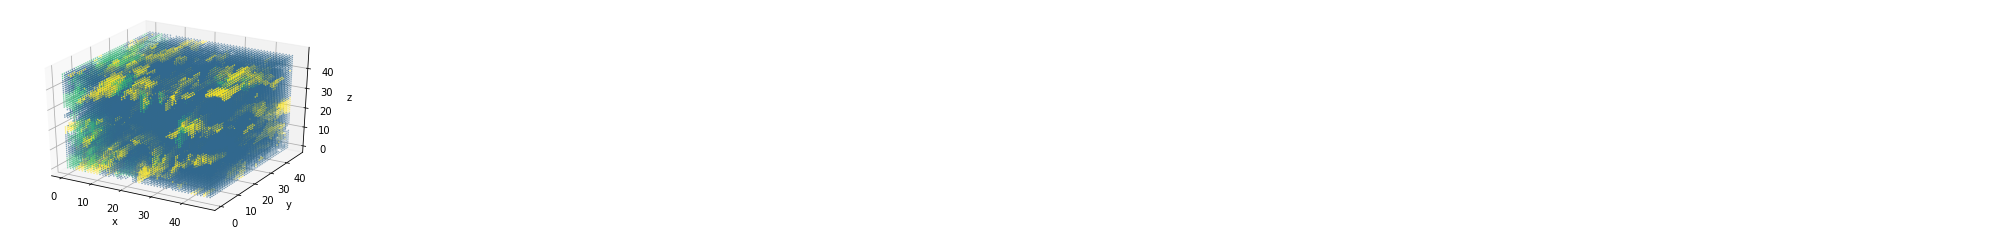

In [62]:
show( one_hot )